In [1]:
#M4.4XLarge EC2
import pandas as pd
import numpy as np
import re
import string
import sys
import os
import datetime

import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

from collections import Counter

from xgboost import XGBClassifier

%matplotlib inline

In [2]:
projects = pd.read_csv('./data/opendata_projects.csv') #878852 Entries
projects = projects.loc[(projects.funding_status == 'completed') | (projects.funding_status == 'expired')] #846164

In [3]:
print "Benchmarks::"
projects.funding_status.value_counts()/projects.shape[0]

Benchmarks::


completed    0.700523
expired      0.299477
Name: funding_status, dtype: float64

In [4]:
#Should generate time stamp as real date for visuals

#projects.set_index('_projectid', inplace =True)
projects['Year'] = projects.date_posted.map(lambda d: d[:4]).astype('int') #Should be Categorical but converting as Int for now
projects['Month'] = projects.date_posted.map(lambda d: d[5:7]).astype('int') #Should be Categorical but converting as Int for now

In [5]:
projects = projects[projects.Year > 2006] #Subset based on plot

In [6]:
#Fix Date Times Vars
for c in projects.columns:
    if 'date' in c:
        projects[c] = pd.to_datetime(projects[c], format="%Y-%m-%d %H:%M:%S")

In [7]:
# project_cols_subset = ['_projectid', '_teacher_acctid', '_schoolid', 
#                        'school_latitude', 'school_longitude', 
#                        'school_city', 'school_state', 'school_zip', 'school_metro',
#                        'school_charter', 'school_magnet', 'school_year_round',
#                        'school_nlns', 'school_kipp', 'school_charter_ready_promise',
#                        'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
#                        'primary_focus_subject', 'primary_focus_area',
#                        'secondary_focus_subject', 'secondary_focus_area',
#                        'resource_type', 'poverty_level', 'grade_level', 
#                        'total_price_excluding_optional_support', 'total_price_including_optional_support',
#                        'students_reached', 'total_donations', 'num_donors',
#                        'eligible_double_your_impact_match', 'eligible_almost_home_match', 'funding_status',
#                        'date_posted', 'date_completed', 'date_thank_you_packet_mailed'] #36 Columns

In [8]:
projects.students_reached.fillna(value = projects.students_reached.median(), inplace = True)

In [9]:
#Feature Engineering 1
project_posted_1 = min(projects.date_posted)
def time_since_first_post(post_date):
    return (post_date - project_posted_1).days

In [10]:
projects['Day'] = projects.date_posted.map(time_since_first_post) #Feature that represents how long since first data point

In [11]:
#Not useful
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

def dt_to_season(dt):
    if dt.dayofyear in spring:
        return 'spring'
    elif dt.dayofyear in summer:
        return 'summer'
    elif dt.dayofyear in fall:
        return 'fall'
    else:
        return 'winter'

In [12]:
projects['season_posted'] = projects.date_posted.map(dt_to_season)

In [13]:
external_zips_xtract = pd.read_csv('./data/census/clean_xtract.csv') #(32653, 27) 2 Obj Columns, Need to fix AltZips

In [14]:
extra_zips = external_zips_xtract.loc[pd.notnull(external_zips_xtract.AltZIPs)]
extra_zips_to_append = pd.DataFrame(columns=external_zips_xtract.columns)

for ind, r in extra_zips.iterrows():
    extra_zip_codes = r.AltZIPs.split()
    for z in extra_zip_codes:
        tmp =  r.copy()
        tmp.zcta5 = z
        extra_zips_to_append = extra_zips_to_append.append(tmp)
        
external_zips_xtract = external_zips_xtract.append(extra_zips_to_append) #This did not help, extra zips not in data

In [15]:
external_zips_xtract.drop('AltZIPs', axis = 1, inplace = True)
external_zips_xtract.CBSAType.fillna('Unknown', inplace = True)

In [16]:
#Lazy method of filling in NaNs should use State information to fill in Nulls
for c in external_zips_xtract.columns:
    if external_zips_xtract[c].dtypes != 'object':
        median = np.median(external_zips_xtract[c][~np.isnan(external_zips_xtract[c])])
        external_zips_xtract[c].fillna(median, inplace = True)

In [17]:
projects = pd.merge(projects, external_zips_xtract, how='left', left_on='school_zip', right_on='zcta5')
projects.set_index('_projectid', inplace = True)

In [18]:
irrelvant_cols = []
for c in projects.columns:
    if projects[c].dtypes == 'object':
        if projects[c].nunique() > 52:
            irrelvant_cols.append(c)
irrelvant_cols += ['school_zip', 'school_latitude', 'school_longitude']            

In [19]:
for c in projects.columns:
    if projects[c].dtypes == '<M8[ns]':
        irrelvant_cols.append(c)

In [20]:
data_leakage = ['total_donations', 'num_donors']
irrelvant_cols += data_leakage

In [21]:
model_target = ['funding_status']

In [22]:
model_df = projects.drop(irrelvant_cols, axis = 1) #Early phase model

enc = {}
for c in model_df.columns:
    if model_df[c].dtype == 'object':
        enc[c] = LabelEncoder()
        model_df[c] = enc[c].fit_transform(model_df[c])

/home/ubuntu/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [23]:
#Lazy way of imputing columns using median
for c in model_df.columns:
    median = np.median(model_df[c][~np.isnan(model_df[c])])
    model_df[c].fillna(median, inplace = True)

In [24]:
X = model_df.drop(model_target, axis = 1).values
y = model_df[model_target].values.ravel()

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [25]:
cols = model_df.drop(model_target, axis = 1).columns #59

In [26]:
 for f in sorted(zip(cols, rf.feature_importances_), key = lambda x: x[1], reverse = True)[:20]:
     print f

('total_price_including_optional_support', 0.06138263863693097)
('payment_processing_charges', 0.061224155505369991)
('Day', 0.054685640981907105)
('total_price_excluding_optional_support', 0.053592277186754404)
('students_reached', 0.034753288134929436)
('Month', 0.027368799740206198)
('vendor_shipping_charges', 0.02632566532749929)
('LandSQMI', 0.023212705670409232)
('sales_tax', 0.023201077608546859)
('primary_focus_subject', 0.023128062037001493)
('secondary_focus_subject', 0.022809913863759773)
('pctRenterOcc', 0.022356579787299179)
('school_ncesid', 0.022071623940092079)
('MedianHValue', 0.021035530413968266)
('pctWhite1', 0.019691564646217609)
('pctForeignBorn', 0.01900027848402961)
('MedianGrossRent', 0.018945814862851903)
('pctInCollege', 0.018654392459228897)
('pctBachelorsormore', 0.018553084873771469)
('pctHispanicPop', 0.018391477328185132)


In [27]:
#PRELIMINARY RESULTS
print rf.score(X_test, y_test)
print rf.oob_score_

0.757465781833
0.746622622504


In [28]:
#Looking at resources requested for each project
f = open('./data/opendata_resources.csv')
header = f.readline().split(',')

header = [c.strip() for c in header]
resources_raw = f.read()
f.close()

resources_row_text = re.split('"\n"', resources_raw)
resouces_for_df = []
for row in resources_row_text:
    resouces_for_df.append(re.split('","', row))
resources = pd.DataFrame(resouces_for_df, columns=header)
del resources_raw
del resources_row_text
del resouces_for_df

In [29]:
resources.iloc[0,0] = resources.iloc[0,0][1:] #fixes the parsing issue
resources.iloc[-1,-1] = 1 #fixes the parsing issue

In [30]:
resources.set_index('_projectid', inplace = True)

resources['vendorid'] = resources.vendorid.map(lambda x: -1 if x == '' else x).astype('int')
resources['vendor_name'] = resources.vendor_name.map(lambda x: 'Unknown' if x == '' else x)
resources['item_name'] = resources.item_name.map(lambda x: 'Unknown' if x == '' else x)
resources['item_number'] = resources.item_number.map(lambda x: -1 if x == '' else x)
resources['item_unit_price'] = resources.item_unit_price.map(lambda x: 14.00 if x == '' else x).astype('float') #median = 13.86 
resources['item_quantity'] = resources.item_quantity.map(lambda x: 1 if x == '' else x).astype('int') #median = 1

resources['price times quantity'] = resources.item_unit_price * resources.item_quantity

In [31]:
#Helper Functions
def join_text(list_str):
    return ' '.join(list_str)

def only_words(s):
    s = s.lower().translate(None, string.punctuation + string.digits)
    return ''.join([c for c in s if c in string.ascii_lowercase + ' '])

In [32]:
resources_gb = resources.groupby(resources.index)
resources_agg = resources_gb.agg({'item_unit_price': [np.min, np.max], 'item_quantity':[np.sum], 'item_name':[join_text], 'price times quantity':[np.sum] })
resources_agg[('item_name','join_text')] = resources_agg[('item_name','join_text')].map(only_words)

resources_agg['avg_price'] = resources_agg[('price times quantity', 'sum')]/resources_agg[('item_quantity','sum')]
#resources_agg.head()

In [33]:
print resources_agg.shape
print model_df.shape

(878528, 6)
(810096, 58)


In [34]:
model_df = model_df.join(resources_agg, how = 'inner')

In [35]:
del projects
del resources_agg

In [36]:
X = model_df.drop([('item_name', 'join_text')] + model_target, axis = 1).values
y = model_df[model_target].values.ravel()

In [37]:
#model_df[('item_name', 'join_text')].head()

In [38]:
if os.path.exists('./model/resource_count_vect.pkl'):
    count_vect = joblib.load('./model/resource_count_vect.pkl')
else:
    print 'Error No Vectorizer'
    #Taken From Resources
    #resource_count_vect = CountVectorizer(stop_words='english', max_features=10000, token_pattern=u'(?u)\\b\\w\\w{2,}\\b') #3 or more letters
    #X = resource_count_vect.fit_transform(data[('item_name', 'join_text')])
    #joblib.dump(resource_count_vect, './model/resource_count_vect.pkl') 
if os.path.exists('./model/resource_nmf_5000.pkl'):
    nmf = joblib.load('./model/resource_nmf_5000.pkl')
else:
    print 'Error No NMF'
#     resource_nmf_5000 = NMF(n_components = 50, max_iter= 10, random_state=42) #Should be 10000
#     X_nmf = resource_nmf_5000.fit_transform(X)
#     joblib.dump(resource_nmf_5000, './model/resource_nmf_5000.pkl') 

In [39]:
X_text = count_vect.transform(model_df[('item_name', 'join_text')])
X_text = nmf.transform(X_text)

In [40]:
n_text_cols = 20 #Only 20 of the 50 are taken since the previous time I had run the RF only the first few were useful

X = np.hstack((X, X_text[:,:n_text_cols]))

In [41]:
indices = np.arange(X.shape[0])

np.random.shuffle(indices,)

X = X[indices]
y = y[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
#Generate Logistic Regression Model
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test, y_test)

0.7018200491798422

In [43]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs = -1, random_state = 1)
rf2.fit(X_train, y_train)

print rf2.score(X_test, y_test)
print rf2.oob_score_

0.751414661123
0.746222620168


In [44]:
for f in sorted(zip(list(cols) + (map(str, range(n_text_cols))), rf2.feature_importances_), key = lambda x: x[1], reverse = True)[:20]:
    print f

('total_price_including_optional_support', 0.037963156162787753)
('payment_processing_charges', 0.036869022368807451)
('Day', 0.036416249098376985)
('total_price_excluding_optional_support', 0.035065267724924166)
('3', 0.031012123466652931)
('2', 0.026373057082262733)
('4', 0.026184028632225072)
('1', 0.023703015561040583)
('students_reached', 0.021461041985162192)
('LandSQMI', 0.020774675897861465)
('pctRenterOcc', 0.019650395461041414)
('Month', 0.019007768872827183)
('MedianHValue', 0.018402015805090207)
('school_ncesid', 0.017759009622624736)
('pctWhite1', 0.017120067859204599)
('vendor_shipping_charges', 0.016352265412307158)
('MedianGrossRent', 0.016332371181713864)
('pctInCollege', 0.016278780994832081)
('pctForeignBorn', 0.016237824582414413)
('pctBachelorsormore', 0.016015436088361566)


In [45]:
#Possibly adding many non-useful columns making model worse

In [46]:
#Should not run this since I have a GridSearch Model pickled
xgb = XGBClassifier(max_depth = 15, subsample=.8, colsample_bytree=.6, n_estimators = 400)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.777189638656541

In [47]:
# grid_params = {'max_depth': [5,10,15], 'subsample': [.6,.8], 'colsample_bytree':[.6,.8], 'n_estimators':[250,500]}

# xgb_rcv = RandomizedSearchCV(XGBClassifier(), param_distributions=grid_params, random_state=1, cv = 4)

# xgb_rcv.fit(X_train, y_train)
# joblib.dump(xgb_rcv, './model/xgb_rcv.pkl')

In [48]:
# xgb_rcv.score(X_test,y_test)

In [63]:
if os.path.exists('./model/xgb_rcv2.pkl'):
    xgb_rcv2 = joblib.load('./model/xgb_rcv2.pkl')
else:
    print 'Need to Train Model!!'

#     grid_params2 = {'max_depth': [12,18], 'subsample': [.8], 'colsample_bytree':[.6], 'n_estimators':[300,600]}
#     xgb_rcv2 = GridSearchCV(XGBClassifier(), param_grid=grid_params2, cv = 4)
#     xgb_rcv2.fit(X_train, y_train)
#     joblib.dump(xgb_rcv2, './model/xgb_rcv2.pkl')

In [74]:
print rf2.score(X_train, y_train)
print rf2.oob_score_
print rf2.score(X_test, y_test)


0.999837054203
0.746222620168
0.751414661123


In [66]:
sorted(xgb_rcv2.grid_scores_, key = lambda x: x[1], reverse = True)

[mean: 0.77446, std: 0.00073, params: {'n_estimators': 600, 'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 18},
 mean: 0.77309, std: 0.00094, params: {'n_estimators': 600, 'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 12},
 mean: 0.77299, std: 0.00095, params: {'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 18},
 mean: 0.77215, std: 0.00039, params: {'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 12}]

In [75]:
print xgb_rcv2.score(X_train, y_train)
print xgb_rcv2.score(X_test, y_test)

0.944764666768
0.94387276444


In [52]:
#GENERATE ROC CURVE

In [54]:
#y_proba = rf.predict_proba(X_test)
#roc_auc_score(y_test, y_proba[:,1])

In [76]:
y_proba = rf2.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:,1])

0.77105818137368842

In [77]:
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(y_test, y_proba[:,1])

In [78]:
y_proba = xgb_rcv2.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:,1])

0.97919125811219909

In [79]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba[:,1])

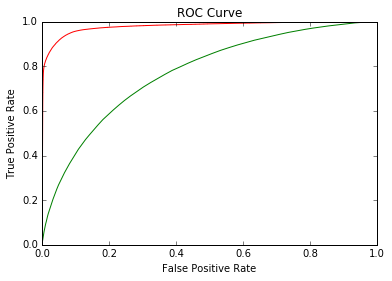

In [80]:
plt.plot(fpr_rf2, tpr_rf2, label='rf2', c = 'g')
plt.plot(fpr_xgb, tpr_xgb, label='xgb', c = 'r')
#plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [81]:
#Further exploration of Topic Modeling Matrices:

vect_vocab = {v: k for k, v in count_vect.vocabulary_.iteritems()}

H = np.load('./model/resource_nmf_5000.pkl_01.npy')

for i in xrange(12):
    print '\n'
    print 'Group: ' + str(i)
    items = np.argsort(H[i])[-30:][::-1]
    print ''
    for j in items:
        print vect_vocab[j], 



Group: 0

illustrator nancy john robert david jane james michael translator brian kevin peter tomie mary chris editor jack robin barbara steven pat harrison ann susan smith martin henkes van paul laura 

Group: 1

level extra nonfiction library book set kgr fiction readers guided reading sightword lexile reader combo rigby right beginning recovery libra platinum fictionnonfiction parent word libraries just plus levels blue sightwords 

Group: 2

set complete library boxed classroom readalongs favorite collection rex paperback leveled write student wipe play giant ball box board piece classic lego jumbo puzzle magnetic class pieces fictionnonfiction games extra 

Group: 3

paper construction amp sulphite superbright green blue holiday red brown dark light pink white orange yellow sheets taye tabu violet targ tabk tavt tapn sky tahg black tawt riverside tard 

Group: 4

series stine goosebumps john vol high jeff nancy rick bluford diary clues riordan street secrets anne smith time clas

Next Possible Steps.. 
Compare vs Neural Network
Add sentiment analysis for full project descriptions (text)
Add the final column that shows whether or not it was a given teachers first project
